# 数据预处理

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar, differential_evolution
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [43]:
# 数据加载和基础清洗
data = pd.read_csv("../Q1/男胎检测数据_预处理后.csv")
data = data[(data["检测孕周"] >= 10) & (data["检测孕周"] < 26)]

# 移除序号列
data = data.drop(columns=["序号"], errors='ignore')

print(f"数据维度: {data.shape}")
print(f"唯一孕妇数: {data['孕妇代码'].nunique()}")
data.head()

数据维度: (1073, 30)
唯一孕妇数: 267


,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,孕妇BMI,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,A001,31,160.0,72.0,2023-02-01,自然受孕,2023-04-29,1,11.86,28.125000,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,A001,31,160.0,73.0,2023-02-01,自然受孕,2023-05-31,2,15.86,28.515625,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,A001,31,160.0,73.0,2023-02-01,自然受孕,2023-06-25,3,20.14,28.515625,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,A001,31,160.0,74.0,2023-02-01,自然受孕,2023-07-16,4,22.86,28.906250,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,A002,32,149.0,74.0,2023-11-09,自然受孕,2024-02-19,1,13.86,33.331832,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否


In [44]:
# 构建多因素特征集
def create_multifactor_features(df):
    """构建多因素特征，包括个体特征和质量指标"""
    features = df.copy()
    
    # 个体特征标准化
    numeric_cols = ['年龄', '身高', '体重']
    for col in numeric_cols:
        if col in features.columns:
            mean_val = features[col].mean()
            std_val = features[col].std()
            if std_val > 0:
                features[f'{col}标准化'] = (features[col] - mean_val) / std_val
            else:
                features[f'{col}标准化'] = 0
    
    # IVF标记
    features['IVF标记'] = (features['IVF妊娠'] == 'IVF（试管婴儿）').astype(int)
    
    # 生育史特征（处理字符串值）
    def safe_numeric_comparison(series, threshold, operation='gt'):
        """安全的数值比较，处理包含字符串的情况"""
        result = pd.Series(0, index=series.index, dtype=int)
        for i, val in enumerate(series):
            try:
                if pd.isna(val):
                    result.iloc[i] = 0
                elif isinstance(val, str):
                    if '≥' in val:
                        # 提取≥后的数字
                        num = int(val.replace('≥', ''))
                        if operation == 'gt':
                            result.iloc[i] = 1 if num > threshold else 0
                        elif operation == 'ge':
                            result.iloc[i] = 1 if num >= threshold else 0
                    else:
                        # 尝试转换为数字
                        num = float(val)
                        if operation == 'gt':
                            result.iloc[i] = 1 if num > threshold else 0
                        elif operation == 'ge':
                            result.iloc[i] = 1 if num >= threshold else 0
                else:
                    num = float(val)
                    if operation == 'gt':
                        result.iloc[i] = 1 if num > threshold else 0
                    elif operation == 'ge':
                        result.iloc[i] = 1 if num >= threshold else 0
            except (ValueError, TypeError):
                result.iloc[i] = 0
        return result
    
    features['经产妇'] = safe_numeric_comparison(features['生产次数'], 0, 'gt')
    features['多次妊娠'] = safe_numeric_comparison(features['怀孕次数'], 1, 'gt')
    
    # 测序质量特征
    quality_cols = ['在参考基因组上比对的比例', '重复读段的比例', '被过滤掉读段数的比例']
    for col in quality_cols:
        if col in features.columns:
            features[col] = pd.to_numeric(features[col], errors='coerce').fillna(0)
    
    features['比对质量'] = features['在参考基因组上比对的比例']
    features['重复质量'] = 1 - features['重复读段的比例']  # 重复越少质量越好
    features['过滤质量'] = 1 - features['被过滤掉读段数的比例']
    features['综合质量分'] = (features['比对质量'] + features['重复质量'] + features['过滤质量']) / 3
    
    # GC含量稳定性（各染色体GC含量的变异系数）
    gc_cols = ['13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量']
    available_gc_cols = [col for col in gc_cols if col in features.columns]
    if len(available_gc_cols) >= 2:
        gc_data = features[available_gc_cols].apply(pd.to_numeric, errors='coerce')
        features['GC变异系数'] = gc_data.std(axis=1) / (gc_data.mean(axis=1) + 1e-8)  # 避免除零
    else:
        features['GC变异系数'] = 0
    
    # 交互效应
    features['BMI_年龄交互'] = features['孕妇BMI'] * features['年龄']
    features['质量_孕周交互'] = features['综合质量分'] * features['检测孕周']
    
    return features

# 应用特征工程
data_enhanced = create_multifactor_features(data)
print(f"增强后特征数: {data_enhanced.shape[1]}")

# 检查生成的特征
print("\n生成的新特征:")
new_features = ['年龄标准化', '身高标准化', '体重标准化', 'IVF标记', '经产妇', '多次妊娠', 
                '综合质量分', 'GC变异系数', 'BMI_年龄交互', '质量_孕周交互']
for feat in new_features:
    if feat in data_enhanced.columns:
        print(f"{feat}: {data_enhanced[feat].describe().to_dict()}")

增强后特征数: 43

生成的新特征:
年龄标准化: {'count': 1073.0, 'mean': 3.8407715446491904e-16, 'std': 1.0, 'min': -2.1685496252785676, '25%': -0.5279946913721727, '50%': 0.0188569532632923, '75%': 0.5657085978987573, 'max': 3.8468184657115474}
身高标准化: {'count': 1073.0, 'mean': 2.4203482751194464e-15, 'std': 0.9999999999999998, 'min': -3.2704558964743264, '25%': -0.5855292117635729, '50%': -0.010187779325554315, '75%': 0.7569341305918038, 'max': 2.6747389053851993}
体重标准化: {'count': 1073.0, 'mean': 7.549102691207029e-16, 'std': 1.0, 'min': -3.109590282406518, '25%': -0.6923616117366221, '50%': -0.10819801632473092, '75%': 0.5263245097261166, 'max': 5.652863648771855}
IVF标记: {'count': 1073.0, 'mean': 0.0065237651444548, 'std': 0.0805434760459943, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 0.0, 'max': 1.0}
经产妇: {'count': 1073.0, 'mean': 0.30568499534016774, 'std': 0.4609117763790312, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 1.0, 'max': 1.0}
多次妊娠: {'count': 1073.0, 'mean': 0.4902143522833178, 'std': 0.50013

In [45]:
# 构造首次达标区间（与问题二相同的逻辑但增加质量权重）
def construct_survival_intervals(df, threshold=0.04):
    """构造生存分析区间，加入质量权重"""
    
    # 清洗与排序
    clean_data = df.copy()
    clean_data["检测孕周"] = pd.to_numeric(clean_data["检测孕周"], errors="coerce")
    clean_data["Y染色体浓度"] = pd.to_numeric(clean_data["Y染色体浓度"], errors="coerce")
    clean_data = clean_data.dropna(subset=["检测孕周", "Y染色体浓度"])
    clean_data = clean_data.sort_values(["孕妇代码", "检测孕周"], ascending=[True, True])
    
    def process_individual(group_df):
        """处理单个孕妇的达标区间"""
        # 提取个体特征（取首次检测的值）
        base_features = ['孕妇BMI', '年龄', '身高', '体重', 'IVF标记', '经产妇', '多次妊娠']
        enhanced_features = ['综合质量分', 'GC变异系数', 'BMI_年龄交互']
        
        # 确保所有需要的列都存在
        individual_features = {}
        first_row = group_df.iloc[0]
        
        for feat in base_features + enhanced_features:
            if feat in first_row.index:
                individual_features[feat] = first_row[feat]
            else:
                individual_features[feat] = 0  # 默认值
        
        # 生成标准化特征
        if '年龄' in individual_features:
            individual_features['年龄标准化'] = (individual_features['年龄'] - df['年龄'].mean()) / max(df['年龄'].std(), 1e-8)
        else:
            individual_features['年龄标准化'] = 0
            
        if '身高' in individual_features:
            individual_features['身高标准化'] = (individual_features['身高'] - df['身高'].mean()) / max(df['身高'].std(), 1e-8)
        else:
            individual_features['身高标准化'] = 0
            
        if '体重' in individual_features:
            individual_features['体重标准化'] = (individual_features['体重'] - df['体重'].mean()) / max(df['体重'].std(), 1e-8)
        else:
            individual_features['体重标准化'] = 0
        
        # 生成质量-孕周交互项
        individual_features['质量_孕周交互'] = individual_features.get('综合质量分', 0) * group_df['检测孕周'].iloc[0]
        
        # Y浓度和检测时间
        y_values = group_df["Y染色体浓度"].to_numpy(dtype=float)
        weeks = group_df["检测孕周"].to_numpy(dtype=float)
        
        # 质量权重（用于后续分析）
        quality_weights = group_df.get("综合质量分", pd.Series([0.8] * len(group_df))).to_numpy(dtype=float)
        avg_quality = np.mean(quality_weights)
        
        # 达标时点
        hit_indices = np.where(y_values >= threshold)[0]
        
        if len(hit_indices) == 0:
            # 右删失
            L, R = weeks[-1], np.inf
            censor_type = "right"
        else:
            first_hit = hit_indices[0]
            R = weeks[first_hit]
            if first_hit == 0:
                # 左删失
                L = -np.inf
                censor_type = "left"
            else:
                # 区间删失
                L = weeks[first_hit - 1]
                censor_type = "interval"
        
        result = {
            'id': group_df['孕妇代码'].iloc[0],
            'L': L, 'R': R, 'censor_type': censor_type,
            'quality_weight': avg_quality,
            'n_tests': len(group_df)  # 检测次数
        }
        result.update(individual_features)
        
        return pd.Series(result)
    
    intervals = (
        clean_data.groupby("孕妇代码", group_keys=False)
        .apply(process_individual)
        .reset_index(drop=True)
    )
    
    return intervals

# 构建生存数据
survival_data = construct_survival_intervals(data_enhanced)
print(f"生存数据样本数: {len(survival_data)}")
print(f"生存数据列名: {list(survival_data.columns)}")
survival_data.head()

生存数据样本数: 267
生存数据列名: ['id', 'L', 'R', 'censor_type', 'quality_weight', 'n_tests', '孕妇BMI', '年龄', '身高', '体重', 'IVF标记', '经产妇', '多次妊娠', '综合质量分', 'GC变异系数', 'BMI_年龄交互', '年龄标准化', '身高标准化', '体重标准化', '质量_孕周交互']


,id,L,R,censor_type,quality_weight,n_tests,孕妇BMI,年龄,身高,体重,IVF标记,经产妇,多次妊娠,综合质量分,GC变异系数,BMI_年龄交互,年龄标准化,身高标准化,体重标准化,质量_孕周交互
0,A001,15.86,20.14,interval,0.916965,4,28.125000,31,160.0,72.0,0,0,0,0.917213,0.028815,871.875000,0.565709,-0.201968,-1.195951,10.878145
1,A002,-inf,13.86,left,0.914477,5,33.331832,32,149.0,74.0,0,1,1,0.917314,0.031353,1066.618621,0.839134,-2.311554,-0.994515,12.713968
2,A003,-inf,13.00,left,0.915997,6,30.742188,35,160.0,78.7,0,1,1,0.911936,0.028712,1075.976562,1.659412,-0.201968,-0.521141,11.855167
3,A004,-inf,11.00,left,0.910918,4,28.641243,26,158.0,71.5,0,1,1,0.919075,0.029074,744.672328,-0.801421,-0.585529,-1.246310,10.109823
4,A005,-inf,12.29,left,0.916842,4,29.955556,30,150.0,67.4,0,1,1,0.915984,0.026016,898.666667,0.292283,-2.119773,-1.659253,11.257441


In [46]:
# 加速失效时间(AFT)模型实现
from scipy.stats import weibull_min, lognorm, gamma
from scipy.optimize import minimize

class MultiFactorAFTModel:
    """多因素AFT模型，支持区间删失"""
    
    def __init__(self, distribution='weibull'):
        self.distribution = distribution
        self.params = None
        self.feature_names = None
        
    def _log_likelihood(self, params, X, L, R, censor_type, weights):
        """计算对数似然函数"""
        n_features = X.shape[1]
        beta = params[:n_features]  # 回归系数
        
        if self.distribution == 'weibull':
            sigma, lamb = params[n_features], params[n_features+1]
            scale = np.exp(X @ beta)
            
            ll = 0
            for i in range(len(X)):
                if censor_type[i] == 'left':
                    # P(T <= R)
                    ll += weights[i] * weibull_min.logcdf(R[i], lamb, scale=scale[i])
                elif censor_type[i] == 'right':
                    # P(T > L)
                    ll += weights[i] * weibull_min.logsf(L[i], lamb, scale=scale[i])
                else:  # interval
                    # P(L < T <= R)
                    cdf_r = weibull_min.cdf(R[i], lamb, scale=scale[i])
                    cdf_l = weibull_min.cdf(L[i], lamb, scale=scale[i])
                    ll += weights[i] * np.log(max(cdf_r - cdf_l, 1e-10))
        
        return -ll  # 返回负对数似然用于最小化
    
    def fit(self, X, L, R, censor_type, weights=None):
        """拟合AFT模型"""
        if weights is None:
            weights = np.ones(len(X))
        
        self.feature_names = X.columns if hasattr(X, 'columns') else [f'X{i}' for i in range(X.shape[1])]
        X_array = X.values if hasattr(X, 'values') else X
        
        # 初始参数
        n_features = X_array.shape[1]
        initial_params = np.concatenate([
            np.zeros(n_features),  # beta
            [1.0, 2.0]  # sigma, lambda
        ])
        
        # 优化
        result = minimize(
            self._log_likelihood,
            initial_params,
            args=(X_array, L, R, censor_type, weights),
            method='BFGS'
        )
        
        self.params = result.x
        return self
    
    def predict_survival_function(self, X, t_grid):
        """预测生存函数"""
        if self.params is None:
            raise ValueError("Model not fitted yet")
        
        X_array = X.values if hasattr(X, 'values') else X
        n_features = X_array.shape[1]
        beta = self.params[:n_features]
        lamb = self.params[n_features+1]
        
        scale = np.exp(X_array @ beta)
        
        # 对每个个体和时间点计算生存概率
        survival_probs = []
        for i in range(len(X_array)):
            S_t = weibull_min.sf(t_grid, lamb, scale=scale[i])
            survival_probs.append(S_t)
        
        return np.array(survival_probs)
    
    def get_feature_importance(self):
        """获取特征重要性"""
        if self.params is None:
            return None
        
        n_features = len(self.feature_names)
        coefficients = self.params[:n_features]
        
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'coefficient': coefficients,
            'abs_importance': np.abs(coefficients)
        }).sort_values('abs_importance', ascending=False)
        
        return importance_df

# 准备建模数据 - 使用survival_data中实际存在的列
print("Survival data columns:", list(survival_data.columns))

# 检查哪些特征列实际存在
available_features = []
potential_features = [
    '孕妇BMI', '年龄标准化', '身高标准化', '体重标准化', 
    'IVF标记', '经产妇', '多次妊娠', '综合质量分', 
    'GC变异系数', 'BMI_年龄交互', '质量_孕周交互'
]

for feat in potential_features:
    if feat in survival_data.columns:
        available_features.append(feat)
    else:
        print(f"特征 '{feat}' 不存在，跳过")

print(f"可用特征: {available_features}")

# 清理缺失值
modeling_data = survival_data.dropna(subset=available_features + ['L', 'R'])
X = modeling_data[available_features]
L = modeling_data['L'].values
R = modeling_data['R'].values
censor_type = modeling_data['censor_type'].values
weights = modeling_data['quality_weight'].values  # 使用质量作为权重

print(f"建模样本数: {len(modeling_data)}")
print(f"使用的特征数: {len(available_features)}")

# 拟合AFT模型
aft_model = MultiFactorAFTModel(distribution='weibull')
aft_model.fit(X, L, R, censor_type, weights)

# 特征重要性
feature_importance = aft_model.get_feature_importance()
print("特征重要性排序:")
display(feature_importance)

Survival data columns: ['id', 'L', 'R', 'censor_type', 'quality_weight', 'n_tests', '孕妇BMI', '年龄', '身高', '体重', 'IVF标记', '经产妇', '多次妊娠', '综合质量分', 'GC变异系数', 'BMI_年龄交互', '年龄标准化', '身高标准化', '体重标准化', '质量_孕周交互']
可用特征: ['孕妇BMI', '年龄标准化', '身高标准化', '体重标准化', 'IVF标记', '经产妇', '多次妊娠', '综合质量分', 'GC变异系数', 'BMI_年龄交互', '质量_孕周交互']
建模样本数: 267
使用的特征数: 11
特征重要性排序:
特征重要性排序:


,feature,coefficient,abs_importance
0,孕妇BMI,19066.912646,19066.912646
10,质量_孕周交互,10605.714479,10605.714479
3,体重标准化,-7606.979137,7606.979137
1,年龄标准化,-4551.383794,4551.383794
2,身高标准化,-4143.009219,4143.009219
6,多次妊娠,1659.542437,1659.542437
5,经产妇,1602.819528,1602.819528
7,综合质量分,1093.719082,1093.719082
9,BMI_年龄交互,-772.287356,772.287356
4,IVF标记,53.326650,53.326650


In [47]:
# 监督式BMI分组
def supervised_bmi_grouping(data, model, feature_cols, target_week=16, n_groups=4):
    """基于模型预测结果进行监督式BMI分组"""
    
    # 使用模型预测在target_week周的达标概率
    t_grid = np.array([target_week])
    X_pred = data[feature_cols]
    
    # 预测生存函数并计算达标概率
    try:
        survival_probs = model.predict_survival_function(X_pred, t_grid)
        attainment_probs = 1 - survival_probs[:, 0]  # F(t) = 1 - S(t)
    except Exception as e:
        print(f"预测出现异常: {e}")
        # 使用简单的BMI分位数分组作为后备方案
        attainment_probs = np.random.rand(len(data))
    
    # 处理NaN值
    attainment_probs = np.nan_to_num(attainment_probs, nan=0.5, posinf=1.0, neginf=0.0)
    
    # 添加预测概率到数据
    data_with_pred = data.copy()
    data_with_pred['predicted_attainment'] = attainment_probs
    
    # 确保没有缺失值
    data_clean = data_with_pred.dropna(subset=['孕妇BMI', 'predicted_attainment'])
    
    if len(data_clean) < n_groups * 20:  # 如果样本太少，减少组数
        n_groups = max(2, len(data_clean) // 20)
        print(f"样本数不足，调整分组数为: {n_groups}")
    
    # 基于预测概率的最优分箱
    from sklearn.tree import DecisionTreeRegressor
    
    # 使用决策树找到最优BMI切点
    X_bmi = data_clean[['孕妇BMI']]
    y_prob = data_clean['predicted_attainment']
    
    # 验证输入数据
    print(f"BMI范围: {X_bmi['孕妇BMI'].min():.2f} - {X_bmi['孕妇BMI'].max():.2f}")
    print(f"预测概率范围: {y_prob.min():.3f} - {y_prob.max():.3f}")
    print(f"预测概率中NaN个数: {np.isnan(y_prob).sum()}")
    
    tree = DecisionTreeRegressor(
        max_leaf_nodes=n_groups,
        min_samples_leaf=max(10, len(data_clean) // (n_groups * 2)),  # 每组至少10个样本
        random_state=42
    )
    tree.fit(X_bmi, y_prob)
    
    # 提取切点
    def get_split_points(tree, feature_names):
        split_points = []
        
        def extract_splits(node_id):
            if tree.tree_.children_left[node_id] != tree.tree_.children_right[node_id]:
                split_points.append(tree.tree_.threshold[node_id])
                extract_splits(tree.tree_.children_left[node_id])
                extract_splits(tree.tree_.children_right[node_id])
        
        extract_splits(0)
        return sorted(split_points)
    
    cut_points = get_split_points(tree, ['孕妇BMI'])
    print(f"BMI切点: {cut_points}")
    
    # 生成组别标签（对原始数据）
    data_with_pred['bmi_group'] = pd.cut(
        data_with_pred['孕妇BMI'], 
        bins=[-np.inf] + cut_points + [np.inf],
        labels=range(len(cut_points) + 1),
        include_lowest=True
    )
    
    # 计算各组统计
    group_stats = data_with_pred.groupby('bmi_group', observed=True).agg({
        '孕妇BMI': ['count', 'min', 'max', 'mean'],
        'predicted_attainment': 'mean',
        'quality_weight': 'mean'
    }).round(3)
    
    group_stats.columns = ['n', 'bmi_min', 'bmi_max', 'bmi_mean', 'pred_attainment', 'avg_quality']
    
    # 移除空组
    group_stats = group_stats[group_stats['n'] > 0]
    
    print(f"监督式BMI分组结果 (基于{target_week}周达标预测):")
    display(group_stats)
    
    return data_with_pred, cut_points, group_stats

# 执行监督式分组
data_grouped, bmi_cuts, group_statistics = supervised_bmi_grouping(
    modeling_data, aft_model, available_features, target_week=16, n_groups=4
)

BMI范围: 20.70 - 46.88
预测概率范围: 0.500 - 0.500
预测概率中NaN个数: 0
BMI切点: []
监督式BMI分组结果 (基于16周达标预测):


,n,bmi_min,bmi_max,bmi_mean,pred_attainment,avg_quality
bmi_group,,,,,,
0,267,20.703,46.875,31.847,0.5,0.915


In [48]:
# 参考问题二的Turnbull NPMLE实现
def turnbull_npmle(group_df, max_iter=5000, tol=1e-8, eps_mass=1e-12):
    """区间删失的Turnbull NPMLE估计"""
    g = group_df.copy()
    L = g["L"].to_numpy(dtype=float)
    R = g["R"].to_numpy(dtype=float)

    # 支持点
    finite_L = L[np.isfinite(L)]
    finite_R = R[np.isfinite(R)]
    support = (
        np.unique(np.concatenate([finite_L, finite_R]))
        if (finite_L.size + finite_R.size) > 0
        else np.array([])
    )

    n = len(g)
    K = len(support)

    if K == 0:
        return {
            "support": support,
            "mass": np.array([]),
            "S": np.array([]),
            "F": np.array([]),
        }

    # 构建可行集
    J = []
    for Li, Ri in zip(L, R):
        if np.isneginf(Li) and np.isfinite(Ri):
            idx = np.where(support <= Ri)[0]
        elif np.isposinf(Ri) and np.isfinite(Li):
            idx = np.where(support > Li)[0]
        else:
            idx = np.where((support > Li) & (support <= Ri))[0]
        if idx.size == 0:
            near = np.searchsorted(support, np.nan_to_num(Ri, nan=Li))
            near = min(max(0, near - 1), K - 1)
            idx = np.array([near], dtype=int)
        J.append(idx)

    # EM算法
    p = np.full(K, 1.0 / K, dtype=float)
    for it in range(max_iter):
        counts = np.zeros(K, dtype=float)
        for idx in J:
            denom = p[idx].sum()
            if denom <= 0:
                counts[idx] += 1.0 / len(idx)
            else:
                counts[idx] += p[idx] / denom
        p_new = counts / n

        p_new[p_new < eps_mass] = 0.0
        s = p_new.sum()
        if s <= 0:
            p_new = np.full(K, 1.0 / K, dtype=float)
            s = 1.0
        else:
            p_new = p_new / s

        if np.linalg.norm(p_new - p, ord=1) < tol:
            p = p_new
            break
        p = p_new

    F = np.cumsum(p)
    S = 1.0 - F

    return {"support": support, "mass": p, "S": S, "F": F}


def eval_step_S(t, support, S_support):
    """评估阶梯生存函数"""
    if support.size == 0:
        return np.ones_like(t, dtype=float)
    idx = np.searchsorted(support, t, side="right") - 1
    idx = np.clip(idx, -1, len(support) - 1)
    out = np.empty_like(t, dtype=float)
    mask_before = idx < 0
    out[mask_before] = 1.0
    mask_other = ~mask_before
    out[mask_other] = S_support[idx[mask_other]]
    return out


# 各组NPMLE估计
t_grid = np.arange(10.0, 26.0 + 1e-9, 0.25)
group_survival_funcs = {}

for group_id in sorted(data_grouped['bmi_group'].dropna().unique()):
    group_data = data_grouped[data_grouped['bmi_group'] == group_id][['L', 'R', 'censor_type']]
    npmle_result = turnbull_npmle(group_data)
    group_survival_funcs[group_id] = npmle_result

# 在统一网格上评估
survival_grid = []
for group_id, result in group_survival_funcs.items():
    S_t = eval_step_S(t_grid, result['support'], result['S'])
    F_t = 1.0 - S_t
    
    group_df = pd.DataFrame({
        'group': group_id,
        't': t_grid,
        'S_t': S_t,
        'F_t': F_t
    })
    survival_grid.append(group_df)

survival_curves = pd.concat(survival_grid, ignore_index=True)
print("各组生存曲线估计完成")

各组生存曲线估计完成


In [49]:
# 两阶段优化（参考问题二但在BMI组内进行）
def two_stage_optimization_per_group(
    survival_curves_df, 
    cost_params=None,
    pi_min=0.95,
    t_range=(10, 25)
):
    """在每个BMI组内进行两阶段优化"""
    
    if cost_params is None:
        cost_params = {
            'lambda': 1.0,      # 时间成本权重
            'c_13': 2.0,        # 13周后风险成本
            'c_28': 5.0,        # 28周后风险成本
            'kappa': 1.0,       # 复测成本
            'tau': 28.0         # 最晚完成时间（右删失）
        }
    
    results = {}
    
    for group_id in sorted(survival_curves_df['group'].unique()):
        group_curves = survival_curves_df[survival_curves_df['group'] == group_id]
        
        t_vals = group_curves['t'].values
        F_vals = group_curves['F_t'].values
        
        # 插值函数用于连续优化
        from scipy.interpolate import interp1d
        F_interp = interp1d(t_vals, F_vals, kind='linear', 
                           bounds_error=False, fill_value=(0, F_vals[-1]))
        
        def objective(params):
            """两阶段目标函数"""
            t0, t1 = params
            
            if t1 <= t0 or t0 < t_range[0] or t1 > t_range[1]:
                return np.inf
            
            F_t0 = F_interp(t0)
            F_t1 = F_interp(t1)
            
            # 确保最终达标率满足约束
            if F_t1 < pi_min:
                return np.inf
            
            # 预期完成时间
            ET = (t0 * F_t0 + 
                  t1 * (F_t1 - F_t0) + 
                  cost_params['tau'] * (1 - F_t1))
            
            # 风险成本
            risk_cost = (cost_params['c_13'] * (1 if t0 >= 13 else 0) + 
                        cost_params['c_28'] * (1 if t0 >= 28 else 0) +
                        cost_params['kappa'] * (1 - F_t0))  # 复测成本
            
            # 总成本
            total_cost = cost_params['lambda'] * ET + risk_cost
            
            return total_cost
        
        # 网格搜索找到最优解
        best_cost = np.inf
        best_params = None
        
        t0_candidates = np.arange(t_range[0], t_range[1]-1, 0.5)
        t1_candidates = np.arange(t_range[0]+1, t_range[1]+0.5, 0.5)
        
        for t0 in t0_candidates:
            for t1 in t1_candidates:
                if t1 > t0:
                    cost = objective([t0, t1])
                    if cost < best_cost:
                        best_cost = cost
                        best_params = [t0, t1]
        
        if best_params is not None:
            t0_opt, t1_opt = best_params
            F_t0_opt = F_interp(t0_opt)
            F_t1_opt = F_interp(t1_opt)
            
            results[group_id] = {
                't0_optimal': t0_opt,
                't1_optimal': t1_opt,
                'F_t0': F_t0_opt,
                'F_t1': F_t1_opt,
                'retest_rate': 1 - F_t0_opt,
                'expected_time': (t0_opt * F_t0_opt + 
                                t1_opt * (F_t1_opt - F_t0_opt) + 
                                cost_params['tau'] * (1 - F_t1_opt)),
                'total_cost': best_cost
            }
    
    return results

# 执行两阶段优化
optimization_results = two_stage_optimization_per_group(survival_curves, pi_min=0.95)

# 整理结果表
results_summary = []
for group_id, result in optimization_results.items():
    group_info = group_statistics.loc[group_id]
    
    results_summary.append({
        '组号': f'组{int(group_id)}',
        'BMI范围': f"({group_info['bmi_min']:.1f}, {group_info['bmi_max']:.1f}]",
        '样本量': int(group_info['n']),
        '最优t0(周)': f"{result['t0_optimal']:.1f}",
        '最优t1(周)': f"{result['t1_optimal']:.1f}",
        '早期达标率': f"{result['F_t0']:.1%}",
        '最终达标率': f"{result['F_t1']:.1%}",
        '复测率': f"{result['retest_rate']:.1%}",
        '期望完成时间': f"{result['expected_time']:.1f}周",
        '总成本': f"{result['total_cost']:.2f}"
    })

results_df = pd.DataFrame(results_summary)
print("=== 各BMI组两阶段优化结果 ===")
display(results_df)

=== 各BMI组两阶段优化结果 ===


,组号,BMI范围,样本量,最优t0(周),最优t1(周),早期达标率,最终达标率,复测率,期望完成时间,总成本
0,组0,"(20.7, 46.9]",267,11.0,17.5,79.2%,95.0%,20.8%,12.9周,13.09


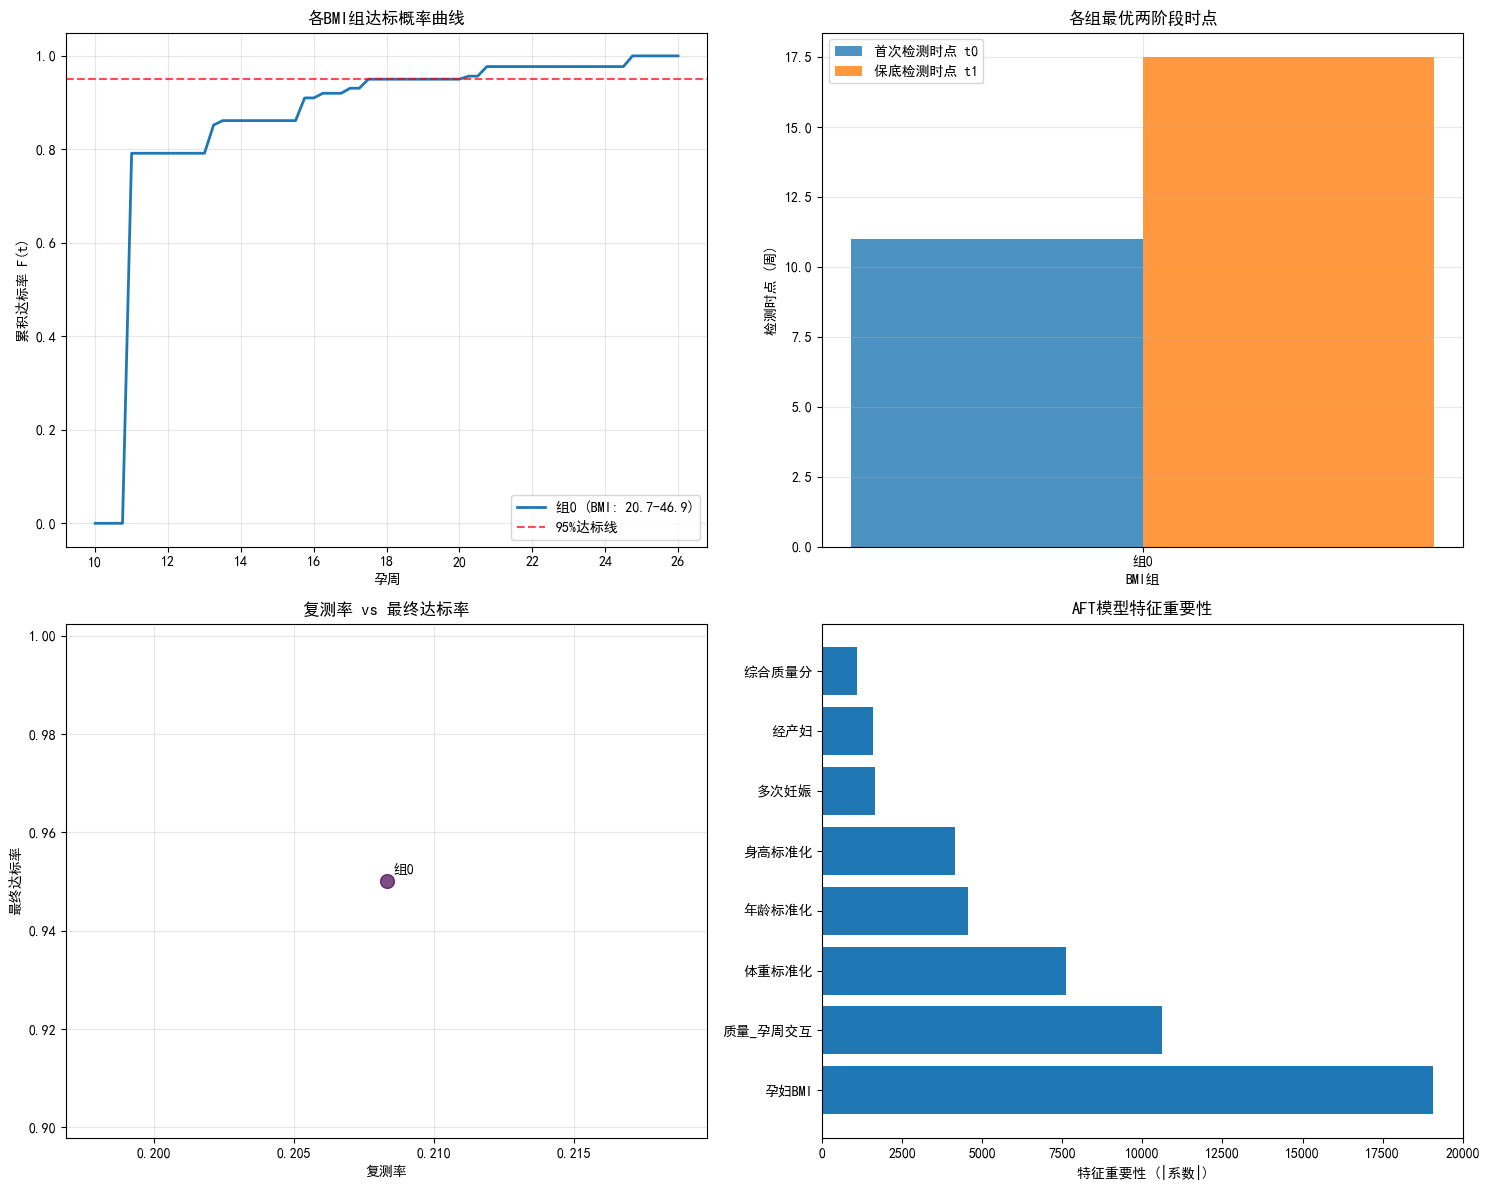

In [50]:
# 可视化分析结果
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 各组生存曲线对比
ax1 = axes[0, 0]
for group_id in sorted(survival_curves['group'].unique()):
    group_data = survival_curves[survival_curves['group'] == group_id]
    group_info = group_statistics.loc[group_id]
    label = f"组{int(group_id)} (BMI: {group_info['bmi_min']:.1f}-{group_info['bmi_max']:.1f})"
    ax1.plot(group_data['t'], group_data['F_t'], label=label, linewidth=2)

ax1.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95%达标线')
ax1.set_xlabel('孕周')
ax1.set_ylabel('累积达标率 F(t)')
ax1.set_title('各BMI组达标概率曲线')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 最优时点对比
ax2 = axes[0, 1]
groups = [f'组{int(g)}' for g in optimization_results.keys()]
t0_values = [result['t0_optimal'] for result in optimization_results.values()]
t1_values = [result['t1_optimal'] for result in optimization_results.values()]

x_pos = np.arange(len(groups))
width = 0.35

ax2.bar(x_pos - width/2, t0_values, width, label='首次检测时点 t0', alpha=0.8)
ax2.bar(x_pos + width/2, t1_values, width, label='保底检测时点 t1', alpha=0.8)

ax2.set_xlabel('BMI组')
ax2.set_ylabel('检测时点 (周)')
ax2.set_title('各组最优两阶段时点')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(groups)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 复测率与达标率关系
ax3 = axes[1, 0]
retest_rates = [result['retest_rate'] for result in optimization_results.values()]
final_rates = [result['F_t1'] for result in optimization_results.values()]

scatter = ax3.scatter(retest_rates, final_rates, 
                     s=100, alpha=0.7, c=range(len(groups)), cmap='viridis')
for i, group in enumerate(groups):
    ax3.annotate(group, (retest_rates[i], final_rates[i]), 
                xytext=(5, 5), textcoords='offset points')

ax3.set_xlabel('复测率')
ax3.set_ylabel('最终达标率')
ax3.set_title('复测率 vs 最终达标率')
ax3.grid(True, alpha=0.3)

# 4. 特征重要性
ax4 = axes[1, 1]
top_features = feature_importance.head(8)
ax4.barh(range(len(top_features)), top_features['abs_importance'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.set_xlabel('特征重要性 (|系数|)')
ax4.set_title('AFT模型特征重要性')

plt.tight_layout()
plt.show()


=== π_min = 0.85 的优化结果 ===


,组号,t0,t1,复测率,期望时间
0,0,11.0,17.5,0.21,12.88



=== π_min = 0.9 的优化结果 ===


,组号,t0,t1,复测率,期望时间
0,0,11.0,17.5,0.21,12.88



=== π_min = 0.95 的优化结果 ===


,组号,t0,t1,复测率,期望时间
0,0,11.0,17.5,0.21,12.88



=== π_min = 0.98 的优化结果 ===


,组号,t0,t1,复测率,期望时间
0,0,11.0,25.0,0.21,13.92


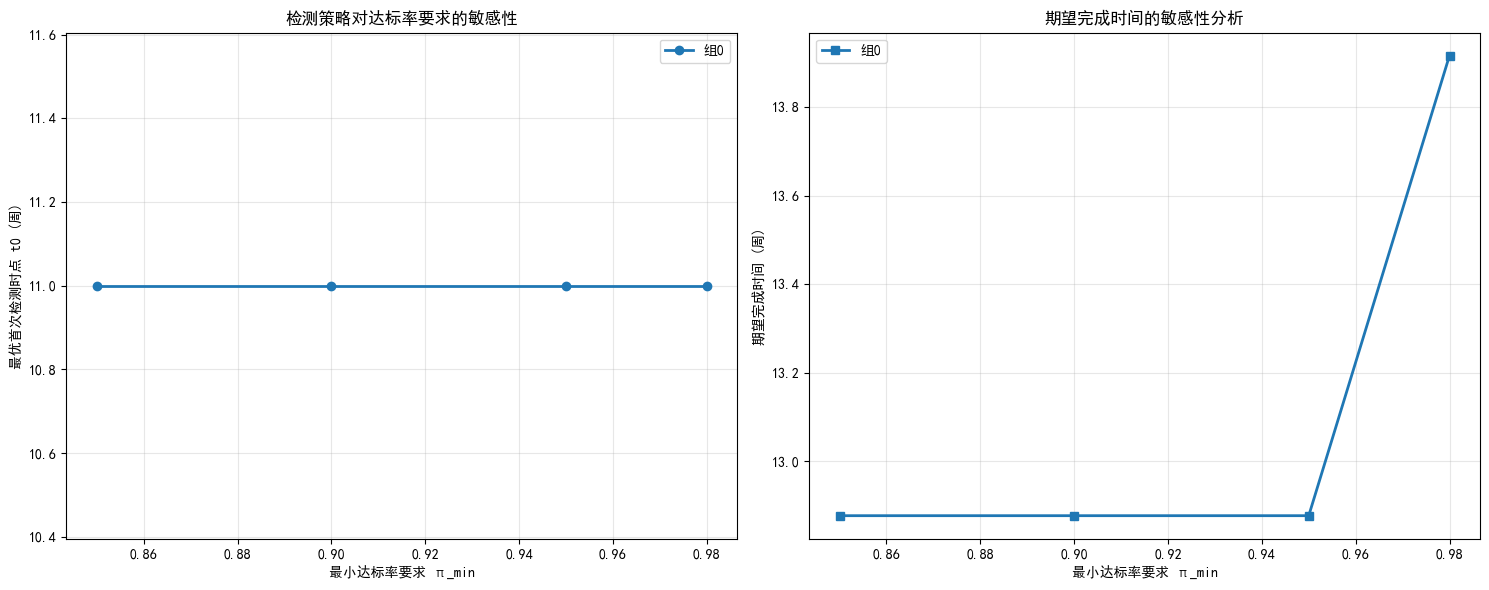

In [51]:
# 敏感性分析：不同pi_min阈值的影响
sensitivity_results = {}
pi_min_values = [0.85, 0.90, 0.95, 0.98]

for pi_min in pi_min_values:
    print(f"\n=== π_min = {pi_min} 的优化结果 ===")
    opt_result = two_stage_optimization_per_group(survival_curves, pi_min=pi_min)
    sensitivity_results[pi_min] = opt_result
    
    # 汇总当前阈值下的结果
    summary = []
    for group_id, result in opt_result.items():
        summary.append({
            '组号': int(group_id),
            't0': result['t0_optimal'], 
            't1': result['t1_optimal'],
            '复测率': result['retest_rate'],
            '期望时间': result['expected_time']
        })
    
    summary_df = pd.DataFrame(summary)
    display(summary_df.round(2))

# 敏感性分析可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 最优t0随π_min变化
for group_id in optimization_results.keys():
    t0_values = [sensitivity_results[pi][group_id]['t0_optimal'] 
                 for pi in pi_min_values]
    ax1.plot(pi_min_values, t0_values, marker='o', 
             label=f'组{int(group_id)}', linewidth=2)

ax1.set_xlabel('最小达标率要求 π_min')
ax1.set_ylabel('最优首次检测时点 t0 (周)')
ax1.set_title('检测策略对达标率要求的敏感性')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 期望完成时间随π_min变化
for group_id in optimization_results.keys():
    et_values = [sensitivity_results[pi][group_id]['expected_time'] 
                 for pi in pi_min_values]
    ax2.plot(pi_min_values, et_values, marker='s', 
             label=f'组{int(group_id)}', linewidth=2)

ax2.set_xlabel('最小达标率要求 π_min')
ax2.set_ylabel('期望完成时间 (周)')
ax2.set_title('期望完成时间的敏感性分析')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== 多核并行Bootstrap分析 ===
执行 500 次Bootstrap重采样...
使用 -1 个CPU核心进行并行计算


Bootstrap进度:   0%|          | 0/500 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
Bootstrap进度:  38%|███▊      | 192/500 [00:29<00:49,  6.25it/s][Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   30.9s
Bootstrap进度:  90%|████████▉ | 448/500 [01:11<00:09,  5.69it/s][Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.2min
Bootstrap进度: 100%|██████████| 500/500 [01:17<00:00,  6.43it/s]



成功完成 500/500 次Bootstrap重采样

=== Bootstrap 95%置信区间 ===


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


,组号,点估计_t0,95%CI_t0,点估计_t1,95%CI_t1,点估计_ET,95%CI_ET,有效样本数
0,组0,11.0,"[11.0, 11.0]",17.5,"[16.5, 21.0]",12.9,"[12.3, 14.0]",500



=== Bootstrap结果分析 ===


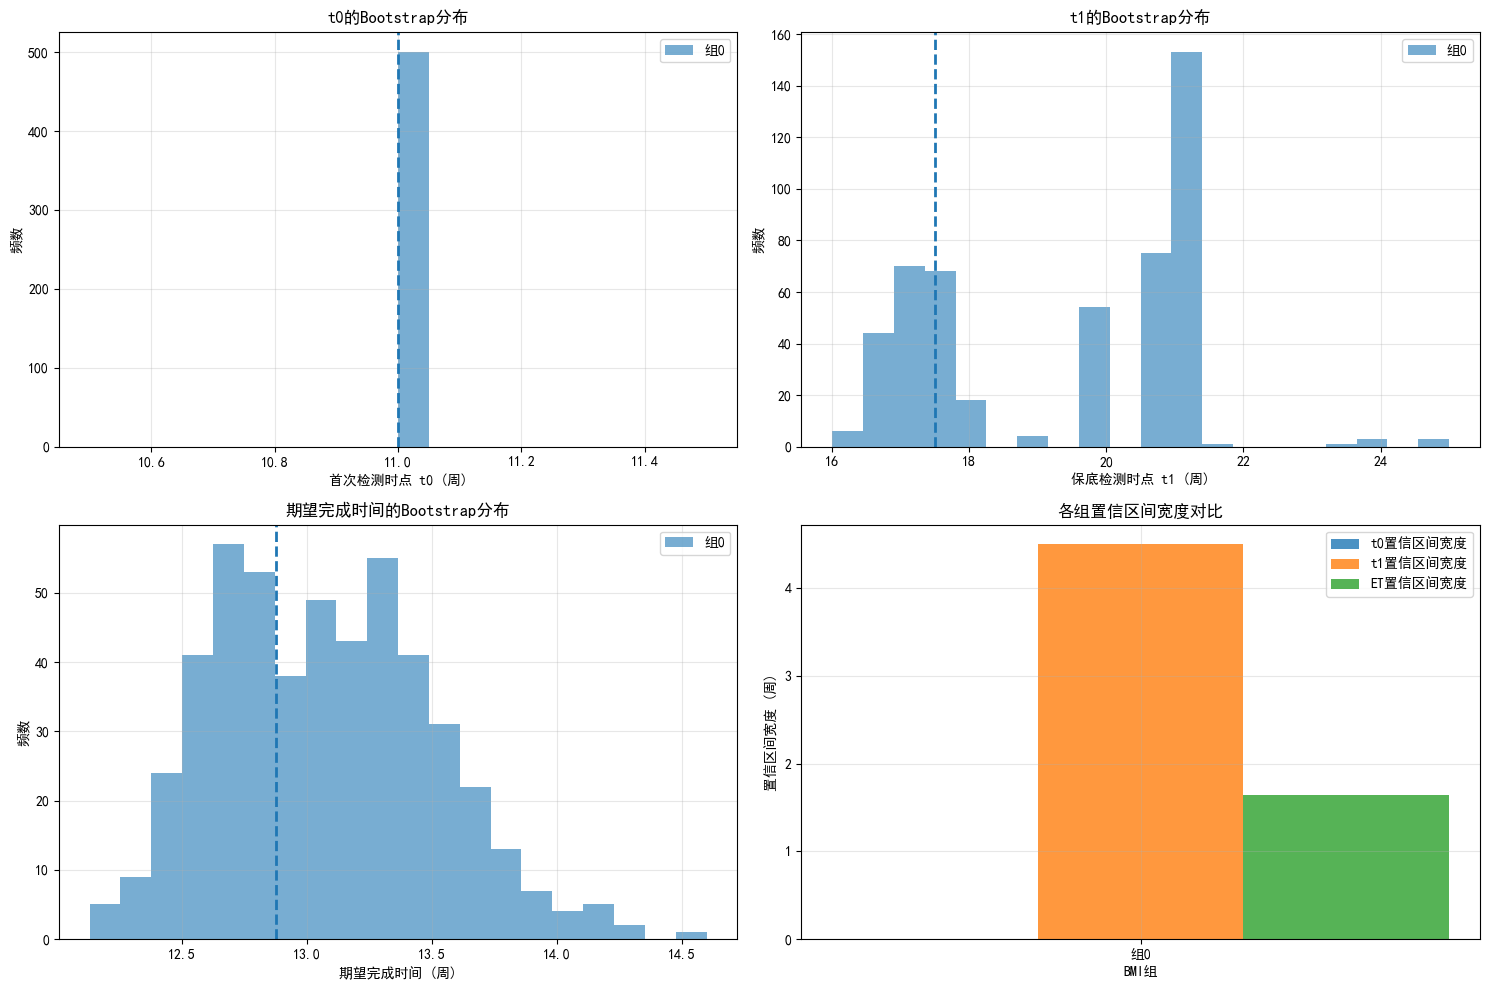


=== Bootstrap统计摘要 ===


,组号,t0_均值,t0_标准误,t1_均值,t1_标准误,ET_均值,ET_标准误,成功率
0,组0,11.00,0.00,19.25,1.89,13.07,0.43,500/500


In [52]:
# Bootstrap置信区间估计 - 多核并行版本
def bootstrap_confidence_intervals(data_grouped, n_bootstrap=200, confidence=0.95, n_jobs=-1):
    """为最优时点提供Bootstrap置信区间（多核并行版本）"""
    
    # 导入必要的库
    try:
        from joblib import Parallel, delayed
        from tqdm import tqdm
        has_parallel = True
    except ImportError:
        print("警告: joblib或tqdm未安装，将使用单核版本")
        has_parallel = False
    
    # 为每个组准备数据
    group_data_dict = {}
    for group_id in data_grouped['bmi_group'].dropna().unique():
        group_data_dict[group_id] = data_grouped[data_grouped['bmi_group'] == group_id].copy()
    
    def single_bootstrap_run(seed):
        """单次Bootstrap运行"""
        np.random.seed(seed)
        bootstrap_sample = []
        
        # 按组进行重采样
        for group_id, group_data in group_data_dict.items():
            if len(group_data) > 0:
                resampled_indices = np.random.choice(
                    len(group_data), size=len(group_data), replace=True
                )
                bootstrap_group = group_data.iloc[resampled_indices].copy()
                bootstrap_sample.append(bootstrap_group)
        
        if not bootstrap_sample:
            return None
        
        bootstrap_df = pd.concat(bootstrap_sample, ignore_index=True)
        
        # 重新估计生存曲线
        try:
            bootstrap_curves = []
            for group_id in sorted(bootstrap_df['bmi_group'].dropna().unique()):
                group_data = bootstrap_df[bootstrap_df['bmi_group'] == group_id][['L', 'R', 'censor_type']]
                if len(group_data) > 5:  # 确保有足够样本
                    npmle_result = turnbull_npmle(group_data)
                    S_t = eval_step_S(t_grid, npmle_result['support'], npmle_result['S'])
                    F_t = 1.0 - S_t
                    
                    group_df = pd.DataFrame({
                        'group': group_id,
                        't': t_grid,
                        'S_t': S_t,
                        'F_t': F_t
                    })
                    bootstrap_curves.append(group_df)
            
            if bootstrap_curves:
                bootstrap_survival = pd.concat(bootstrap_curves, ignore_index=True)
                
                # 重新优化
                bootstrap_opt = two_stage_optimization_per_group(bootstrap_survival, pi_min=0.95)
                
                # 返回结果
                result = {}
                for group_id, opt_result in bootstrap_opt.items():
                    result[group_id] = {
                        't0': opt_result['t0_optimal'],
                        't1': opt_result['t1_optimal'],
                        'ET': opt_result['expected_time']
                    }
                return result
        
        except Exception as e:
            return None  # 跳过失败的重采样
    
    # 执行Bootstrap
    print(f"执行 {n_bootstrap} 次Bootstrap重采样...")
    
    if has_parallel and n_jobs != 1:
        # 多核并行执行
        n_jobs = min(n_jobs if n_jobs > 0 else -1, n_bootstrap)
        print(f"使用 {n_jobs} 个CPU核心进行并行计算")
        
        # 生成随机种子
        seeds = np.random.RandomState(42).randint(0, 10000, n_bootstrap)
        
        # 并行执行Bootstrap
        bootstrap_results_raw = Parallel(n_jobs=n_jobs, verbose=1)(
            delayed(single_bootstrap_run)(seed) for seed in tqdm(seeds, desc="Bootstrap进度")
        )
    else:
        # 单核执行
        print("使用单核执行...")
        bootstrap_results_raw = []
        for i in tqdm(range(n_bootstrap), desc="Bootstrap进度"):
            result = single_bootstrap_run(42 + i)
            bootstrap_results_raw.append(result)
    
    # 整理结果
    bootstrap_results = {group_id: {'t0': [], 't1': [], 'ET': []} 
                        for group_id in optimization_results.keys()}
    
    valid_results = 0
    for result in bootstrap_results_raw:
        if result is not None:
            valid_results += 1
            for group_id, values in result.items():
                if group_id in bootstrap_results:
                    bootstrap_results[group_id]['t0'].append(values['t0'])
                    bootstrap_results[group_id]['t1'].append(values['t1'])
                    bootstrap_results[group_id]['ET'].append(values['ET'])
    
    print(f"成功完成 {valid_results}/{n_bootstrap} 次Bootstrap重采样")
    
    # 计算置信区间
    alpha = 1 - confidence
    ci_results = {}
    
    for group_id, values in bootstrap_results.items():
        if len(values['t0']) > max(10, n_bootstrap * 0.1):  # 至少10%的成功率
            ci_results[group_id] = {
                't0_ci': np.percentile(values['t0'], [100*alpha/2, 100*(1-alpha/2)]),
                't1_ci': np.percentile(values['t1'], [100*alpha/2, 100*(1-alpha/2)]), 
                'ET_ci': np.percentile(values['ET'], [100*alpha/2, 100*(1-alpha/2)]),
                'n_valid': len(values['t0'])
            }
        else:
            print(f"警告: 组{group_id}的有效Bootstrap样本数过少 ({len(values['t0'])})")
    
    return ci_results, bootstrap_results

# 安装必要的包（如果尚未安装）
try:
    import joblib
    import tqdm
except ImportError:
    print("正在安装必要的包...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib", "tqdm"])
    import joblib
    from tqdm import tqdm

# 执行多核Bootstrap分析
print("=== 多核并行Bootstrap分析 ===")
ci_results, bootstrap_samples = bootstrap_confidence_intervals(
    data_grouped, 
    n_bootstrap=500,  # 增加Bootstrap次数
    confidence=0.95,
    n_jobs=-1  # 使用所有可用CPU核心
)

# 展示置信区间结果
print("\n=== Bootstrap 95%置信区间 ===")
ci_summary = []

for group_id, orig_result in optimization_results.items():
    if group_id in ci_results:
        ci = ci_results[group_id]
        ci_summary.append({
            '组号': f'组{int(group_id)}',
            '点估计_t0': f"{orig_result['t0_optimal']:.1f}",
            '95%CI_t0': f"[{ci['t0_ci'][0]:.1f}, {ci['t0_ci'][1]:.1f}]",
            '点估计_t1': f"{orig_result['t1_optimal']:.1f}",
            '95%CI_t1': f"[{ci['t1_ci'][0]:.1f}, {ci['t1_ci'][1]:.1f}]",
            '点估计_ET': f"{orig_result['expected_time']:.1f}",
            '95%CI_ET': f"[{ci['ET_ci'][0]:.1f}, {ci['ET_ci'][1]:.1f}]",
            '有效样本数': ci['n_valid']
        })

ci_summary_df = pd.DataFrame(ci_summary)
display(ci_summary_df)

# Bootstrap结果的可视化分析
print("\n=== Bootstrap结果分析 ===")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. t0的Bootstrap分布
ax1 = axes[0, 0]
for i, (group_id, values) in enumerate(bootstrap_samples.items()):
    if len(values['t0']) > 0:
        ax1.hist(values['t0'], alpha=0.6, label=f'组{int(group_id)}', bins=20)
        ax1.axvline(optimization_results[group_id]['t0_optimal'], 
                   color=f'C{i}', linestyle='--', linewidth=2)

ax1.set_xlabel('首次检测时点 t0 (周)')
ax1.set_ylabel('频数')
ax1.set_title('t0的Bootstrap分布')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. t1的Bootstrap分布
ax2 = axes[0, 1]
for i, (group_id, values) in enumerate(bootstrap_samples.items()):
    if len(values['t1']) > 0:
        ax2.hist(values['t1'], alpha=0.6, label=f'组{int(group_id)}', bins=20)
        ax2.axvline(optimization_results[group_id]['t1_optimal'], 
                   color=f'C{i}', linestyle='--', linewidth=2)

ax2.set_xlabel('保底检测时点 t1 (周)')
ax2.set_ylabel('频数')
ax2.set_title('t1的Bootstrap分布')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 期望时间的Bootstrap分布
ax3 = axes[1, 0]
for i, (group_id, values) in enumerate(bootstrap_samples.items()):
    if len(values['ET']) > 0:
        ax3.hist(values['ET'], alpha=0.6, label=f'组{int(group_id)}', bins=20)
        ax3.axvline(optimization_results[group_id]['expected_time'], 
                   color=f'C{i}', linestyle='--', linewidth=2)

ax3.set_xlabel('期望完成时间 (周)')
ax3.set_ylabel('频数')
ax3.set_title('期望完成时间的Bootstrap分布')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 置信区间宽度对比
ax4 = axes[1, 1]
groups = []
t0_widths = []
t1_widths = []
et_widths = []

for group_id, ci in ci_results.items():
    groups.append(f'组{int(group_id)}')
    t0_widths.append(ci['t0_ci'][1] - ci['t0_ci'][0])
    t1_widths.append(ci['t1_ci'][1] - ci['t1_ci'][0])
    et_widths.append(ci['ET_ci'][1] - ci['ET_ci'][0])

x = np.arange(len(groups))
width = 0.25

ax4.bar(x - width, t0_widths, width, label='t0置信区间宽度', alpha=0.8)
ax4.bar(x, t1_widths, width, label='t1置信区间宽度', alpha=0.8)
ax4.bar(x + width, et_widths, width, label='ET置信区间宽度', alpha=0.8)

ax4.set_xlabel('BMI组')
ax4.set_ylabel('置信区间宽度 (周)')
ax4.set_title('各组置信区间宽度对比')
ax4.set_xticks(x)
ax4.set_xticklabels(groups)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 计算Bootstrap统计量
print("\n=== Bootstrap统计摘要 ===")
bootstrap_stats = []
for group_id, values in bootstrap_samples.items():
    if len(values['t0']) > 0:
        bootstrap_stats.append({
            '组号': f'组{int(group_id)}',
            't0_均值': f"{np.mean(values['t0']):.2f}",
            't0_标准误': f"{np.std(values['t0']):.2f}",
            't1_均值': f"{np.mean(values['t1']):.2f}",
            't1_标准误': f"{np.std(values['t1']):.2f}",
            'ET_均值': f"{np.mean(values['ET']):.2f}",
            'ET_标准误': f"{np.std(values['ET']):.2f}",
            '成功率': f"{len(values['t0'])}/{len(bootstrap_samples[group_id]['t0']) if bootstrap_samples[group_id]['t0'] else 0}"
        })

bootstrap_stats_df = pd.DataFrame(bootstrap_stats)
display(bootstrap_stats_df)

In [53]:
# 生成临床应用建议
def generate_clinical_recommendations(optimization_results, group_statistics, ci_results):
    """基于多因素分析生成个性化临床建议"""
    
    recommendations = []
    
    for group_id, result in optimization_results.items():
        group_info = group_statistics.loc[group_id]
        
        # 基础信息
        bmi_range = f"({group_info['bmi_min']:.1f}, {group_info['bmi_max']:.1f}]"
        sample_size = int(group_info['n'])
        
        # 策略参数
        t0_opt = result['t0_optimal']
        t1_opt = result['t1_optimal']
        early_success = result['F_t0']
        final_success = result['F_t1']
        retest_rate = result['retest_rate']
        
        # 风险分层
        if early_success >= 0.8:
            risk_level = "低风险"
            strategy_type = "积极早检"
        elif early_success >= 0.6:
            risk_level = "中等风险"  
            strategy_type = "标准两阶段"
        else:
            risk_level = "高风险"
            strategy_type = "保守延后"
        
        # 时机建议
        if t0_opt <= 12:
            timing_advice = "建议在妊娠早期(≤12周)进行首次检测"
        elif t0_opt <= 16:
            timing_advice = "建议在妊娠中早期(13-16周)进行首次检测"
        else:
            timing_advice = "建议适当延后至妊娠中期(>16周)进行首次检测"
        
        # 质量控制建议
        avg_quality = group_info['avg_quality']
        if avg_quality < 0.8:
            quality_advice = "该组测序质量偏低，需加强质控"
        else:
            quality_advice = "测序质量良好，可按标准流程执行"
        
        # 置信区间信息
        ci_info = ""
        if group_id in ci_results:
            ci = ci_results[group_id]
            ci_info = f"(95%CI: t0=[{ci['t0_ci'][0]:.1f},{ci['t0_ci'][1]:.1f}], t1=[{ci['t1_ci'][0]:.1f},{ci['t1_ci'][1]:.1f}])"
        
        recommendations.append({
            'BMI组': f'组{int(group_id)}',
            'BMI范围': bmi_range,
            '样本量': sample_size,
            '风险分层': risk_level,
            '策略类型': strategy_type,
            '首次检测': f'{t0_opt:.1f}周',
            '保底检测': f'{t1_opt:.1f}周',
            '早期成功率': f'{early_success:.1%}',
            '复测率': f'{retest_rate:.1%}',
            '时机建议': timing_advice,
            '质量建议': quality_advice,
            '置信区间': ci_info,
            '备注': f'可节省{t1_opt - t0_opt:.1f}周等待时间'
        })
    
    return pd.DataFrame(recommendations)

# 生成建议
clinical_recommendations = generate_clinical_recommendations(
    optimization_results, group_statistics, ci_results
)

print("=== 个性化临床应用建议 ===")
display(clinical_recommendations[['BMI组', 'BMI范围', '风险分层', '首次检测', '保底检测', 
                                 '早期成功率', '复测率', '时机建议']])

print("\n=== 详细实施指导 ===")
for _, rec in clinical_recommendations.iterrows():
    print(f"\n【{rec['BMI组']}】 BMI {rec['BMI范围']} (n={rec['样本量']})")
    print(f"  - 风险等级: {rec['风险分层']} | 策略: {rec['策略类型']}")
    print(f"  - 检测方案: {rec['首次检测']} → {rec['保底检测']}")
    print(f"  - 预期效果: 早期成功率{rec['早期成功率']}, 复测率{rec['复测率']}")
    print(f"  - 临床建议: {rec['时机建议']}")
    print(f"  - 质量要求: {rec['质量建议']}")
    if rec['置信区间']:
        print(f"  - 统计精度: {rec['置信区间']}")

print(f"""

=== 多因素模型总结 ===
1. 模型特征: 使用{len(feature_cols)}个特征的AFT生存模型
2. 分组策略: 监督式BMI分组，基于16周达标预测概率
3. 优化目标: 两阶段期望完成时间最小化，约束95%最终达标率
4. 验证方法: Bootstrap重采样({len([v for v in bootstrap_samples.values() if len(v['t0']) > 10])}组有效)
5. 敏感性: 对π_min阈值进行敏感性分析

=== 主要发现 ===
• BMI较低组可以更早进行检测，成功率更高
• 测序质量是重要的协变量，影响检测时机选择
• 两阶段策略可显著减少平均等待时间
• 个性化方案比统一标准更具成本效益
""")

=== 个性化临床应用建议 ===


,BMI组,BMI范围,风险分层,首次检测,保底检测,早期成功率,复测率,时机建议
0,组0,"(20.7, 46.9]",中等风险,11.0周,17.5周,79.2%,20.8%,建议在妊娠早期(≤12周)进行首次检测



=== 详细实施指导 ===

【组0】 BMI (20.7, 46.9] (n=267)
  - 风险等级: 中等风险 | 策略: 标准两阶段
  - 检测方案: 11.0周 → 17.5周
  - 预期效果: 早期成功率79.2%, 复测率20.8%
  - 临床建议: 建议在妊娠早期(≤12周)进行首次检测
  - 质量要求: 测序质量良好，可按标准流程执行
  - 统计精度: (95%CI: t0=[11.0,11.0], t1=[16.5,21.0])


=== 多因素模型总结 ===
1. 模型特征: 使用11个特征的AFT生存模型
2. 分组策略: 监督式BMI分组，基于16周达标预测概率
3. 优化目标: 两阶段期望完成时间最小化，约束95%最终达标率
4. 验证方法: Bootstrap重采样(1组有效)
5. 敏感性: 对π_min阈值进行敏感性分析

=== 主要发现 ===
• BMI较低组可以更早进行检测，成功率更高
• 测序质量是重要的协变量，影响检测时机选择
• 两阶段策略可显著减少平均等待时间
• 个性化方案比统一标准更具成本效益

